# 00 - Preparation

In [208]:
from nimlab import datasets as nimds
import numpy as np
from nilearn import image, plotting, maskers
import nibabel as nib
import os
import pandas as pd
import glob
import platform
import warnings
warnings.filterwarnings('ignore')
import nilearn

Set BIDS Directory Information

In [209]:
## Paths Input Here
bids_base_directory = '/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/grafman/derivatives'
session_number = '01'
#----------------------------------------------------------------DO NOT TOUCH
out_dir = os.path.join(bids_base_directory, 'neuroimaging_analyses', (f'ses-{session_number}'), 'sub-all', 'spatial_correlation')
print('Will save to: ', out_dir)
os.makedirs(out_dir, exist_ok=True)

Will save to:  /Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/grafman/derivatives/neuroimaging_analyses/ses-01/sub-all/spatial_correlation


# 01 - Imports

**A) Import Niftis from Folders**

**Import The First Matrix**

Enter Information Relating to the Path of the First Set of Niftis

In [210]:
basename_target_1 = r'/Users/cu135/Dropbox (Partners HealthCare)/studies/ccm_memory/neuroimaging/derivatives/memory_maps/rFz'
file_pattern_target_1 = r'*.nii*'


Enter Information Regarding How You Want to Handle the Niftis

In [211]:
remove_zero = False
z_score_df1 = False
rfz_transform_target1 = False
threshold_df1 = False
take_absolute_value = False

Import the Niftis

In [212]:
import numpy as np
from calvin_utils.file_utils.import_matrices import import_matrices_from_folder
from calvin_utils.nifti_utils.matrix_utilities import threshold_matrix

def process_matrices(
    basename_target, 
    file_pattern_target, 
    z_score_df=False, 
    rfz_transform_target=False, 
    threshold_df=False, 
    take_absolute_value=True
):
    """
    Process matrices from a given directory and file pattern.
    
    Parameters:
    - basename_target (str): Path to the directory containing the matrices.
    - file_pattern_target (str): File pattern to match matrices.
    - remove_zero (bool, optional): A flag which, if implemented, would remove zero values. Default is False.
    - z_score_df (bool, optional): Apply z-scoring to the matrices. Default is False.
    - rfz_transform_target (bool, optional): Apply Fisher's r-to-z transformation to the matrices. Default is False.
    - threshold_df (bool, optional): Apply thresholding to the matrices. Default is False.
    - take_absolute_value (bool, optional): Convert matrix values to their absolute values. Default is True.
    
    Returns:
    - DataFrame: Processed matrices
    """
    
    matrix_df = import_matrices_from_folder(connectivity_path=basename_target, file_pattern=file_pattern_target)
    
    if z_score_df:
        from calvin_utils.statistical_utils.z_score_matrix import z_score_matrix
        for col in matrix_df.columns:
            matrix_df[col] = matrix_df[col].apply(lambda x: z_score_matrix(x))
    
    if rfz_transform_target:
        from calvin_utils.statistical_utils.fisher_z_transform import fisher_z_transform
        for col in matrix_df.columns:
            matrix_df[col] = matrix_df[col].apply(lambda x: fisher_z_transform(x))
    
    if threshold_df:
        matrix_df = threshold_matrix(matrix_df, threshold=2, probability=False, direction='keep_greater')
    
    if take_absolute_value:
        matrix_df = np.abs(matrix_df)
    
    return matrix_df


In [213]:
matrix_df1 = process_matrices(
    basename_target=basename_target_1,
    file_pattern_target=file_pattern_target_1,
    z_score_df=z_score_df1,
    rfz_transform_target=rfz_transform_target1,
    threshold_df=threshold_df1,
    take_absolute_value=take_absolute_value,
)
matrix_df1.tail(3)

I will search:  /Users/cu135/Dropbox (Partners HealthCare)/studies/ccm_memory/neuroimaging/derivatives/memory_maps/rFz/*.nii*


,Grafman_gvar699.nii,SANTE_Memory_Difficulties_24mo.nii,Grafman_gvar698.nii,SANTE_Trouble_Memory_12mo.nii,Grafman_gvar705.nii,Voss_TMS.nii,SANTE_Memory_Difficultues_6mo.nii,SANTE_Trouble_Memory_6mo.nii,SANTE_Trouble_Remebering_24mo.nii,Grafman_gvar704.nii,...,Grafman_gvar702.nii,SANTE_Trouble_Remembering_6mo.nii,Corbetta_Memory_Verbal.nii,SANTE_Trouble_Memory_24mo.nii,SANTE_Memory_Difficulties_12mo.nii,MS_Memory.nii,Grafman_MMSE_Q5.nii,SANTE_Trouble_Remembering_12mo.nii,Corbetta_Memory_Spatial.nii,Grafman_gvar697.nii
902626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Import the Second Matrix**

Enter Information Relating to the Path of the First Set of Niftis

In [214]:
basename_target_2 = r'/Users/cu135/Dropbox (Partners HealthCare)/resources/published_networks/niftis'
file_pattern_target_2 = r'Memory Network T Conn.nii'


Enter Information Regarding How You Want to Handle the Niftis

In [215]:
z_score_df2 = False
rfz_transform_target2 = False
threshold_df2 = False
take_absolute_value2 = False

Import the Niftis

In [216]:
matrix_df2 = process_matrices(
    basename_target=basename_target_2,
    file_pattern_target=file_pattern_target_2,
    z_score_df=z_score_df2,
    rfz_transform_target=rfz_transform_target2,
    threshold_df=threshold_df2,
    take_absolute_value=take_absolute_value2,
)
matrix_df2.tail(3)

I will search:  /Users/cu135/Dropbox (Partners HealthCare)/resources/published_networks/niftis/Memory Network T Conn.nii


,Memory Network T Conn.nii
902626,0.0
902627,0.0
902628,0.0


Merge Dataframes

In [217]:
import pandas as pd
import numpy as np

def join_dataframes(matrix_df1, matrix_df2):
    """
    Joins two dataframes side by side and returns the merged dataframe.
    
    Parameters:
    - matrix_df1 (DataFrame): The first dataframe to join.
    - matrix_df2 (DataFrame): The second dataframe to join.
    
    Returns:
    - DataFrame: The merged dataframe created by joining matrix_df1 and matrix_df2 side by side.
    """
    
    # Reset indexes of the input dataframes
    matrix_df1.reset_index()
    matrix_df2.reset_index()
    
    # Print lengths of the dataframes
    print('df1 len: ', len(matrix_df1), ' matrix_df2 len: ', len(matrix_df2))
    
    # Concatenate the dataframes side by side
    merged_df = pd.concat([matrix_df1, matrix_df2], axis=1, ignore_index=False)
    
    # Print the number of non-zero elements in the last column
    print('Nonzero values in last column: ', np.count_nonzero(merged_df.iloc[:,-1]))
    try:
        merged_df.pop('index')
    except:
        pass
    return merged_df

# Example usage:
# Assuming matrix_df1 and matrix_df2 are already defined
# result_df = join_dataframes(matrix_df1, matrix_df2)


In [218]:
merged_df = join_dataframes(matrix_df1, matrix_df2)
merged_df

df1 len:  902629  matrix_df2 len:  902629
Nonzero values in last column:  292019


,Grafman_gvar699.nii,SANTE_Memory_Difficulties_24mo.nii,Grafman_gvar698.nii,SANTE_Trouble_Memory_12mo.nii,Grafman_gvar705.nii,Voss_TMS.nii,SANTE_Memory_Difficultues_6mo.nii,SANTE_Trouble_Memory_6mo.nii,SANTE_Trouble_Remebering_24mo.nii,Grafman_gvar704.nii,...,SANTE_Trouble_Remembering_6mo.nii,Corbetta_Memory_Verbal.nii,SANTE_Trouble_Memory_24mo.nii,SANTE_Memory_Difficulties_12mo.nii,MS_Memory.nii,Grafman_MMSE_Q5.nii,SANTE_Trouble_Remembering_12mo.nii,Corbetta_Memory_Spatial.nii,Grafman_gvar697.nii,Memory Network T Conn.nii
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**B) Import Niftis from a CSV**

In [219]:
# from calvin_utils.file_utils.import_matrices import import_matrices_from_csv
# merged_df = import_matrices_from_csv('/Users/cu135/Dropbox (Partners HealthCare)/studies/ccm_memory/metadata/path_to_sante_rho_maps.csv')
# merged_df

from calvin_utils.file_utils import import_matrices_from_csv


Mask Within A Given Template Space

# 02 - Masking

In [220]:
import numpy as np
from nimlab import datasets as nimds
from nilearn import image

def apply_mask_to_dataframe(merged_df, mask_path=None):
    """
    Apply a mask to a dataframe using either a provided mask or the default MNI ICBM152 mask.
    
    Parameters:
    - merged_df (DataFrame): The dataframe to which the mask should be applied.
    - mask_path (str, optional): The path to the mask image. If not provided, the MNI ICBM152 mask will be used.
    
    Returns:
    - DataFrame: The masked dataframe containing only the rows specified by the mask.
    
    Example usage:
    >>> masked_df = apply_mask_to_dataframe(merged_df, mask_path=None)
    """
    
    # Load the mask data based on the provided mask_path or use default mask
    if mask_path is not None:
        brain_indices = np.where(image.load_img(mask_path).get_fdata().flatten() > 0)[0]
    else:
        mni_mask = nimds.get_img("mni_icbm152")
        mask_data = mni_mask.get_fdata().flatten()
        brain_indices = np.where(mask_data > 0)[0]
    
    # Apply the mask to the dataframe
    masked_df = merged_df.iloc[brain_indices]
    
    return masked_df




In [221]:
masked_df = apply_mask_to_dataframe(merged_df, mask_path=None)


# 03 - Spatial Correlation

**Perform Correlation**

method_choices:
- 0 = pearson
- 1 = spearman
- 2 = kendall

In [222]:
method_choice = 0
only_compare_nonzero_voxels=True

In [223]:
import pandas as pd
from tqdm import tqdm
from natsort import natsorted

def compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=False):
    """
    Compute correlations among columns of a DataFrame using a specified method.
    When only_compare_nonzero_voxels is True, only pairs of non-zero voxels are used for the computation.
    
    Parameters:
    - df (DataFrame): The dataframe for which correlations should be computed.
    - method_choice (int, optional): An integer indicating the correlation method to be used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    - only_compare_nonzero_voxels (bool, optional): Flag to determine whether to compute correlations 
                                                    considering only non-zero voxels. Default is False.
    
    Returns:
    - DataFrame: The correlation matrix.
    
    Example usage:
    >>> corr_matrix = compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=True)
    """
    
    methods = ['pearson', 'spearman', 'kendall']
    method = methods[method_choice]
    
    # If only_compare_nonzero_voxels is False, compute the correlation in the usual manner
    if not only_compare_nonzero_voxels:
        return df.corr(method=method), method
    else:
        columns = df.columns
        n = len(columns)
        
        # Initialize a dataframe to store the results
        corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64')
        
        # Iterate over each pair of columns
        for i in tqdm(range(n)):
            for j in range(i, n):
                # Filter rows where both columns have non-zero values
                temp_df = df[(df[columns[i]] != 0) & (df[columns[j]] != 0)]
                
                # Compute correlation for the filtered rows
                corr_value = temp_df[[columns[i], columns[j]]].corr(method=method).iloc[0, 1]
                
                # Assign the computed value to the result dataframe
                corr_df.iloc[i, j] = corr_value
                corr_df.iloc[j, i] = corr_value
                
    #Sort the Dataframe            
    corr_df = corr_df.reindex(index=natsorted(corr_df.index))
    corr_df = corr_df.reindex(columns=natsorted(corr_df.columns))
    return corr_df, method


In [224]:
only_compare_nonzero_voxels=True

In [225]:
corr_df, method = compute_correlation(masked_df, method_choice=method_choice, 
                                      only_compare_nonzero_voxels=only_compare_nonzero_voxels)
corr_df

100%|██████████| 26/26 [00:02<00:00,  8.79it/s]


,Corbetta_Memory_Spatial.nii,Corbetta_Memory_Verbal.nii,Ferguson_Amnesia.nii,Grafman_MMSE_Q5.nii,Grafman_gvar697.nii,Grafman_gvar698.nii,Grafman_gvar699.nii,Grafman_gvar700.nii,Grafman_gvar701.nii,Grafman_gvar702.nii,...,SANTE_Memory_Difficulties_12mo.nii,SANTE_Memory_Difficulties_24mo.nii,SANTE_Memory_Difficultues_6mo.nii,SANTE_Trouble_Memory_6mo.nii,SANTE_Trouble_Memory_12mo.nii,SANTE_Trouble_Memory_24mo.nii,SANTE_Trouble_Remebering_24mo.nii,SANTE_Trouble_Remembering_6mo.nii,SANTE_Trouble_Remembering_12mo.nii,Voss_TMS.nii
Corbetta_Memory_Spatial.nii,1.000000,0.258458,-0.021162,-0.150789,-0.174565,0.005114,0.148760,0.294421,0.181837,-0.110258,...,-0.061487,-0.118666,0.127314,-0.065560,0.042639,-0.082715,-0.046641,-0.065992,-0.038081,0.017677
Corbetta_Memory_Verbal.nii,0.258458,1.000000,-0.179066,0.237715,-0.068872,-0.167924,-0.344014,-0.337058,-0.095453,0.208359,...,-0.120397,-0.138118,0.070939,0.030705,0.114002,0.098452,-0.012071,-0.001169,0.038580,0.040851
Ferguson_Amnesia.nii,-0.021162,-0.179066,1.000000,-0.173681,0.030835,0.120279,0.325925,0.309969,0.082534,-0.173519,...,0.031578,0.083603,-0.050996,0.062445,0.031431,-0.015269,-0.039069,0.034516,0.008693,-0.147291
Grafman_MMSE_Q5.nii,-0.150789,0.237715,-0.173681,1.000000,0.009371,-0.091280,-0.288412,-0.483802,-0.254904,-0.087144,...,-0.131159,-0.151420,-0.069700,0.023784,0.045109,0.129526,0.073307,0.043437,0.020782,0.162509
Grafman_gvar697.nii,-0.174565,-0.068872,0.030835,0.009371,1.000000,0.522791,0.178297,-0.360772,-0.181726,-0.105398,...,-0.079453,-0.165435,-0.181856,0.032769,-0.140118,0.131596,0.179130,0.280452,0.013671,0.026859
Grafman_gvar698.nii,0.005114,-0.167924,0.120279,-0.091280,0.522791,1.000000,0.460761,-0.115002,0.154467,-0.233960,...,-0.150445,-0.207257,-0.187533,-0.114956,-0.286265,-0.140906,0.087931,0.251527,-0.164549,0.047287
Grafman_gvar699.nii,0.148760,-0.344014,0.325925,-0.288412,0.178297,0.460761,1.000000,0.198711,0.157613,-0.352624,...,0.056786,-0.006413,-0.082984,-0.225400,-0.236488,-0.169994,0.144337,0.146919,-0.033630,-0.278292
Grafman_gvar700.nii,0.294421,-0.337058,0.309969,-0.483802,-0.360772,-0.115002,0.198711,1.000000,0.298552,-0.079717,...,0.174323,0.287091,0.265258,0.065585,0.216240,-0.148417,-0.261903,-0.254749,0.039265,-0.190884
Grafman_gvar701.nii,0.181837,-0.095453,0.082534,-0.254904,-0.181726,0.154467,0.157613,0.298552,1.000000,0.097521,...,0.012951,0.056929,0.041476,-0.305537,-0.122761,-0.182987,-0.054326,-0.161652,-0.086596,0.012705
Grafman_gvar702.nii,-0.110258,0.208359,-0.173519,-0.087144,-0.105398,-0.233960,-0.352624,-0.079717,0.097521,1.000000,...,-0.178285,-0.049930,0.000721,0.039037,0.063242,0.072090,-0.160979,-0.106568,-0.175310,0.035554


**Visualize the Correlation Matrix**

<AxesSubplot: >

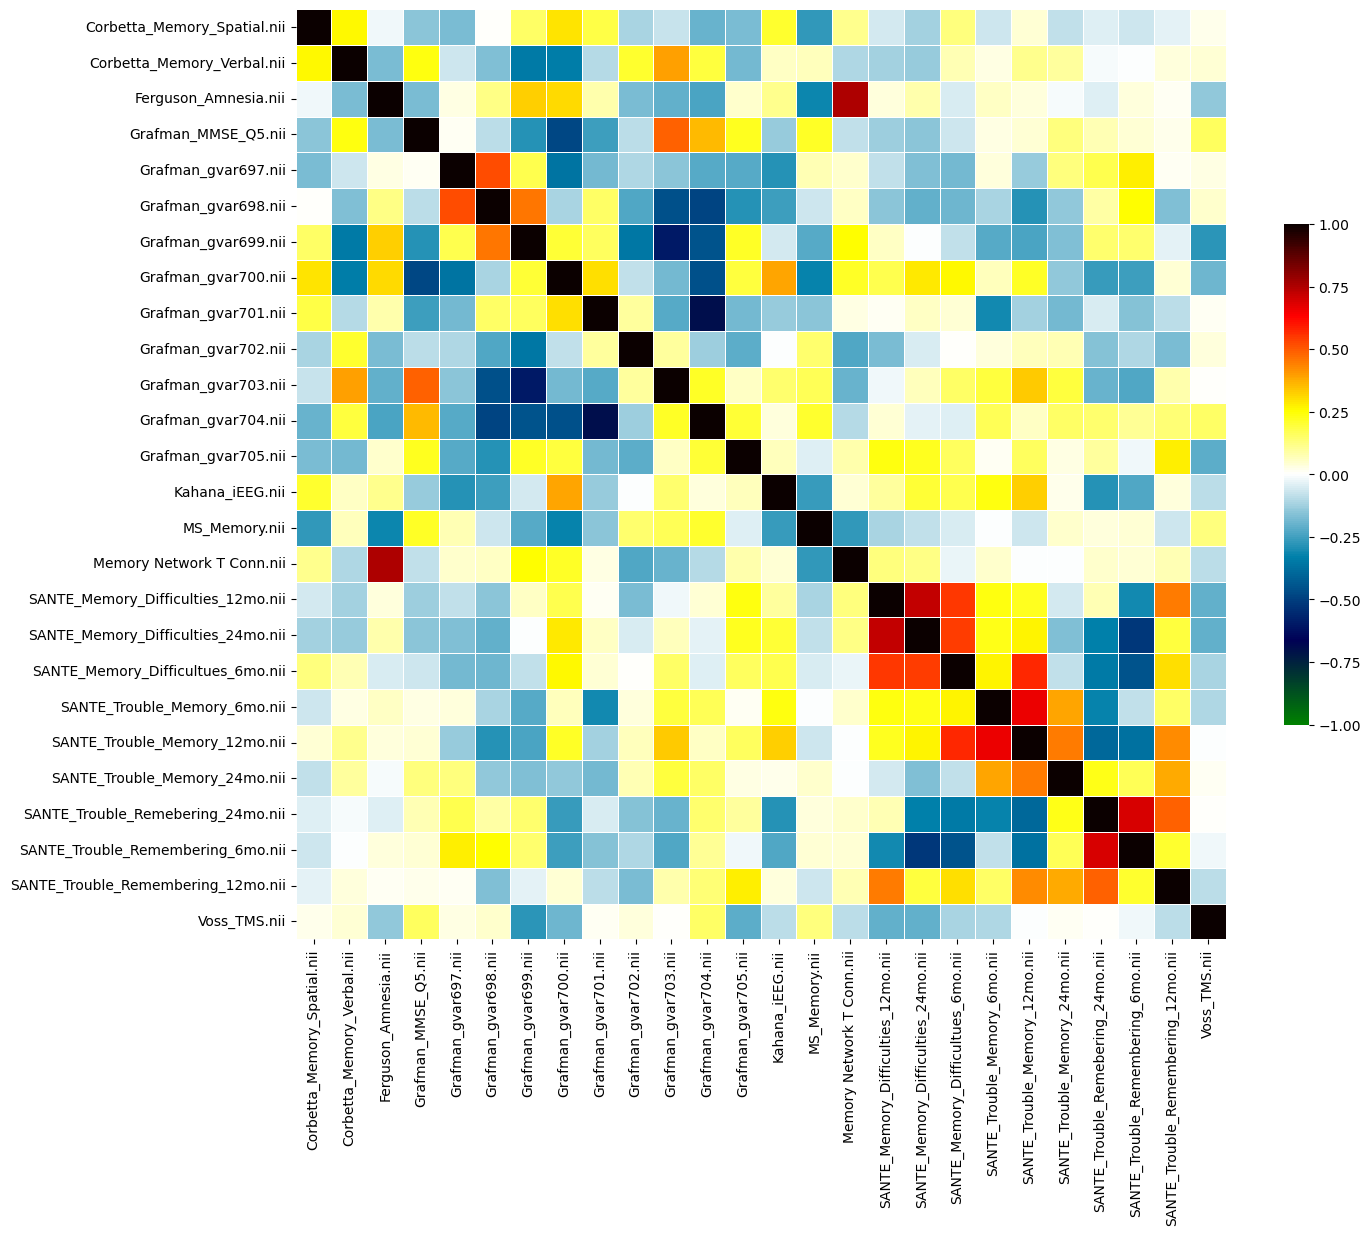

In [226]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)          

**Save The Figure & Dataframe**
- enter the name of your comparison below

In [ ]:
import os

def save_correlation_results(corr_df, fig, out_dir, comparison, save=False, method_choice=0):
    """
    Save the correlation dataframe and figure to specified output directory.
    
    Parameters:
    - out_dir (str): The base directory where the results should be saved.
    - comparison (str): The specific comparison or sub-directory under out_dir.
    - save (bool, optional): Flag to determine whether to save results. Default is False.
    - method_choice (int, optional): An integer indicating the correlation method used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    
    Example usage:
    >>> save_correlation_results('/path/to/output', 'specific_comparison', save=True, method_choice=1)
    """
    
    if save:
        out_dir = os.path.join(out_dir, comparison)
        os.makedirs(out_dir, exist_ok=True)

        corr_df.to_csv(os.path.join(out_dir, f'{method_choice}_correlation_df.csv'))
        fig.savefig(os.path.join(out_dir, f'{method_choice}_correlation_matrix.png'))
        print('saved to ' + os.path.join(out_dir, f'{method_choice}_correlation_matrix.png'))


In [ ]:
comparison = 'z_score_atrophy_index'
save_results = True

In [ ]:
save_correlation_results(corr_df=corr_df, fig=fig, out_dir=out_dir, comparison=comparison, save=save_results, method_choice=method_choice)

**Extract the Cross-Correlation Matrix**

In [ ]:
def extract_cross_correlation_diagonal(corr_df):
    """
    Extracts the diagonal of the cross-correlation from the given correlation matrix.
    
    Parameters:
    - corr_df (DataFrame): The correlation matrix.
    
    Returns:
    - DataFrame: The diagonal of the cross-correlation with the patient identifiers as the index.
    
    Example usage:
    >>> cross_corr_diag = extract_cross_correlation_diagonal(corr_df)
    """
    
    # Assuming the dataframe is square and has an even number of columns,
    # split it into two equal parts
    n = len(corr_df)
    half_n = n // 2
    
    # Extract the values from the intersection of the rows of the first dataset 
    # and the columns of the second dataset
    cross_corr_values = [corr_df.iloc[i, i + half_n] for i in range(half_n)]
    
    # Convert to DataFrame while maintaining the index from the original corr_df
    cross_corr_df = pd.DataFrame(cross_corr_values, index=corr_df.index[:half_n], columns=["Cross-Correlation"])
    
    return cross_corr_df



In [ ]:
cross_corr_diagonal_df = extract_cross_correlation_diagonal(corr_df)
cross_corr_diagonal_df

In [ ]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(cross_corr_diagonal_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)       

Save Results

In [ ]:
import os

def save_cross_correlation_results(corr_df, fig, out_dir, comparison, save=False, method_choice=0):
    """
    Save the correlation dataframe and figure to specified output directory.
    
    Parameters:
    - out_dir (str): The base directory where the results should be saved.
    - comparison (str): The specific comparison or sub-directory under out_dir.
    - save (bool, optional): Flag to determine whether to save results. Default is False.
    - method_choice (int, optional): An integer indicating the correlation method used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    
    Example usage:
    >>> save_correlation_results('/path/to/output', 'specific_comparison', save=True, method_choice=1)
    """
    
    if save:
        out_dir = os.path.join(out_dir, comparison)
        os.makedirs(out_dir, exist_ok=True)

        corr_df.to_csv(os.path.join(out_dir, f'{method_choice}_cross_correlation_df.csv'))
        fig.savefig(os.path.join(out_dir, f'{method_choice}_cross_correlation_matrix.png'))
        print('saved to ' + os.path.join(out_dir, f'{method_choice}_cross_correlation_matrix.png'))

In [ ]:
save_results = True

In [ ]:
save_cross_correlation_results(corr_df=cross_corr_diagonal_df, fig=fig, out_dir=out_dir, comparison=comparison, save=save_results, method_choice=method_choice)

## Show Specific Heatmap

In [227]:
print(corr_df.columns)

Index(['Corbetta_Memory_Spatial.nii', 'Corbetta_Memory_Verbal.nii',
       'Ferguson_Amnesia.nii', 'Grafman_MMSE_Q5.nii', 'Grafman_gvar697.nii',
       'Grafman_gvar698.nii', 'Grafman_gvar699.nii', 'Grafman_gvar700.nii',
       'Grafman_gvar701.nii', 'Grafman_gvar702.nii', 'Grafman_gvar703.nii',
       'Grafman_gvar704.nii', 'Grafman_gvar705.nii', 'Kahana_iEEG.nii',
       'MS_Memory.nii', 'Memory Network T Conn.nii',
       'SANTE_Memory_Difficulties_12mo.nii',
       'SANTE_Memory_Difficulties_24mo.nii',
       'SANTE_Memory_Difficultues_6mo.nii', 'SANTE_Trouble_Memory_6mo.nii',
       'SANTE_Trouble_Memory_12mo.nii', 'SANTE_Trouble_Memory_24mo.nii',
       'SANTE_Trouble_Remebering_24mo.nii',
       'SANTE_Trouble_Remembering_6mo.nii',
       'SANTE_Trouble_Remembering_12mo.nii', 'Voss_TMS.nii'],
      dtype='object')


In [ ]:
#Enter networks of interest
network_of_interest = 'Memory Network.nii'
networks_of_disinterest = [
    None   
]

#---isolate network of interest and remove those not of interest
corr_df_2 = corr_df.copy()
corr_df_2 = pd.DataFrame(corr_df_2.loc[:, network_of_interest])
if networks_of_disinterest[0] is not None:
    for network in networks_of_disinterest:
        corr_df_2.drop(network, inplace=True)
#Sort the dataframe by descending order
corr_df_2 = corr_df_2.sort_values(network_of_interest)
#Remove .nii from file names
for name in corr_df_2.columns.values:
    newname = name.split('.nii')[0]
    corr_df_2 = corr_df_2.rename({name: newname}, axis='columns')
for name in corr_df_2.index.values:
    newname = name.split('.nii')[0]
    corr_df_2 = corr_df_2.rename({name: newname}, axis='index')

#---Visualize the new data
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))

sns.heatmap(corr_df_2, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)

#Save results
fig.savefig(out_dir + f'/spcorrel_{network_of_interest}.png')
fig.savefig(out_dir + f'/spcorrel_{network_of_interest}.svg')
corr_df_2.to_csv(out_dir + f'/spcorrel_{network_of_interest}.csv')
display(corr_df_2)
print(out_dir)

# Compute Agreement

In [228]:
def compute_agreement(df, method_choice='dice'):
    """
    Compute agreement among columns of a DataFrame using a specified method.
    
    Parameters:
    - df (DataFrame): The dataframe for which agreement should be computed.
    - method_choice (str, optional): A string indicating the agreement method to be used. 
                                     'dice': Dice Coefficient, 'jaccard': Jaccard Index, 'percent': % Agreement
    
    Returns:
    - Tuple(DataFrame, DataFrame, DataFrame): Positive agreement matrix, Negative agreement matrix, Overall agreement matrix.
    """
    
    columns = df.columns
    n = len(columns)
    
    # Initialize dataframes to store the results
    pos_corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64') if method_choice != 'percent' else None
    neg_corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64') if method_choice != 'percent' else None
    overall_corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64')
    
    # Binarize the DataFrame
    bin_df = df.applymap(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    # Iterate over each pair of columns
    for i in range(n):
        for j in range(i, n):
            
            col1, col2 = columns[i], columns[j]
            
            # Indices where both columns have the same sign (either both positive or both negative)
            same_sign = (bin_df[col1] == bin_df[col2]) & (bin_df[col1] != 0)
            
            # Indices where both columns are positive, negative, or any
            both_pos = (bin_df[col1] == 1) & (bin_df[col2] == 1)
            both_neg = (bin_df[col1] == -1) & (bin_df[col2] == -1)
            
            if method_choice == 'dice':
                # Dice Coefficient
                pos_value = 2 * both_pos.sum() / (bin_df[col1].eq(1).sum() + bin_df[col2].eq(1).sum())
                neg_value = 2 * both_neg.sum() / (bin_df[col1].eq(-1).sum() + bin_df[col2].eq(-1).sum())
                
            elif method_choice == 'jaccard':
                # Jaccard Index
                pos_value = both_pos.sum() / ((bin_df[col1] == 1) | (bin_df[col2] == 1)).sum()
                neg_value = both_neg.sum() / ((bin_df[col1] == -1) | (bin_df[col2] == -1)).sum()
                
            elif method_choice == 'percent':
                # % Agreement of voxels sharing the same sign
                overall_value = same_sign.sum() / len(bin_df)
                overall_corr_df.loc[col1, col2] = overall_value
                overall_corr_df.loc[col2, col1] = overall_value
                continue
            
            overall_value = (pos_value + neg_value) / 2
            
            # Update DataFrames
            if pos_corr_df is not None:
                pos_corr_df.loc[col1, col2] = pos_value
                pos_corr_df.loc[col2, col1] = pos_value
            if neg_corr_df is not None:
                neg_corr_df.loc[col1, col2] = neg_value
                neg_corr_df.loc[col2, col1] = neg_value
            overall_corr_df.loc[col1, col2] = overall_value
            overall_corr_df.loc[col2, col1] = overall_value
    
    return pos_corr_df, neg_corr_df, overall_corr_df


In [236]:
pos_corr_df, neg_corr_df, overall_corr_df = compute_agreement(masked_df, 'percent')

Positive Agreement

In [237]:
display(pos_corr_df)

None

In [238]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(pos_corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)    

ValueError: Must pass 2-d input. shape=()

<Figure size 1500x1300 with 0 Axes>

Negative Agreement

In [ ]:
display(neg_corr_df)

,Grafman_gvar699.nii,SANTE_Memory_Difficulties_24mo.nii,Grafman_gvar698.nii,SANTE_Trouble_Memory_12mo.nii,Grafman_gvar705.nii,Voss_TMS.nii,SANTE_Memory_Difficultues_6mo.nii,SANTE_Trouble_Memory_6mo.nii,SANTE_Trouble_Remebering_24mo.nii,Grafman_gvar704.nii,...,SANTE_Trouble_Remembering_6mo.nii,Corbetta_Memory_Verbal.nii,SANTE_Trouble_Memory_24mo.nii,SANTE_Memory_Difficulties_12mo.nii,MS_Memory.nii,Grafman_MMSE_Q5.nii,SANTE_Trouble_Remembering_12mo.nii,Corbetta_Memory_Spatial.nii,Grafman_gvar697.nii,Memory Network T Conn.nii
Grafman_gvar699.nii,1.000000,0.478043,0.683363,0.445694,0.559914,0.444439,0.456708,0.483776,0.612116,0.381389,...,0.647380,0.527651,0.500892,0.530459,0.556660,0.459854,0.539178,0.655469,0.636947,0.602724
SANTE_Memory_Difficulties_24mo.nii,0.478043,1.000000,0.434103,0.530640,0.523885,0.408780,0.621133,0.527307,0.422324,0.439548,...,0.388765,0.476376,0.415964,0.751501,0.499165,0.426449,0.553837,0.503549,0.451101,0.540771
Grafman_gvar698.nii,0.683363,0.434103,1.000000,0.430377,0.399203,0.562372,0.441425,0.558604,0.659461,0.456829,...,0.714632,0.624597,0.556366,0.496871,0.642564,0.565405,0.545934,0.655218,0.771318,0.586890
SANTE_Trouble_Memory_12mo.nii,0.445694,0.530640,0.430377,1.000000,0.498042,0.497038,0.704523,0.705839,0.372813,0.486921,...,0.431655,0.567399,0.629789,0.539469,0.519021,0.534248,0.629708,0.556525,0.471524,0.516565
Grafman_gvar705.nii,0.559914,0.523885,0.399203,0.498042,1.000000,0.377159,0.489096,0.471818,0.530704,0.523607,...,0.537268,0.449349,0.486457,0.559526,0.522091,0.550575,0.582334,0.508290,0.444293,0.507790
Voss_TMS.nii,0.444439,0.408780,0.562372,0.497038,0.377159,1.000000,0.441292,0.499406,0.545228,0.601645,...,0.552810,0.609817,0.535701,0.433652,0.640264,0.604805,0.505835,0.606682,0.563219,0.457027
SANTE_Memory_Difficultues_6mo.nii,0.456708,0.621133,0.441425,0.704523,0.489096,0.441292,1.000000,0.581523,0.375677,0.450062,...,0.404968,0.553382,0.478539,0.631174,0.510921,0.486649,0.596981,0.578602,0.446444,0.513157
SANTE_Trouble_Memory_6mo.nii,0.483776,0.527307,0.558604,0.705839,0.471818,0.499406,0.581523,1.000000,0.500932,0.574717,...,0.593002,0.604338,0.690965,0.589916,0.606380,0.561972,0.605456,0.595446,0.593338,0.561495
SANTE_Trouble_Remebering_24mo.nii,0.612116,0.422324,0.659461,0.372813,0.530704,0.545228,0.375677,0.500932,1.000000,0.625359,...,0.846954,0.655125,0.647915,0.567954,0.671779,0.595900,0.713430,0.672216,0.686225,0.606124
Grafman_gvar704.nii,0.381389,0.439548,0.456829,0.486921,0.523607,0.601645,0.450062,0.574717,0.625359,1.000000,...,0.627376,0.647953,0.607531,0.516325,0.681594,0.677835,0.588062,0.589142,0.540296,0.493285


<AxesSubplot: >

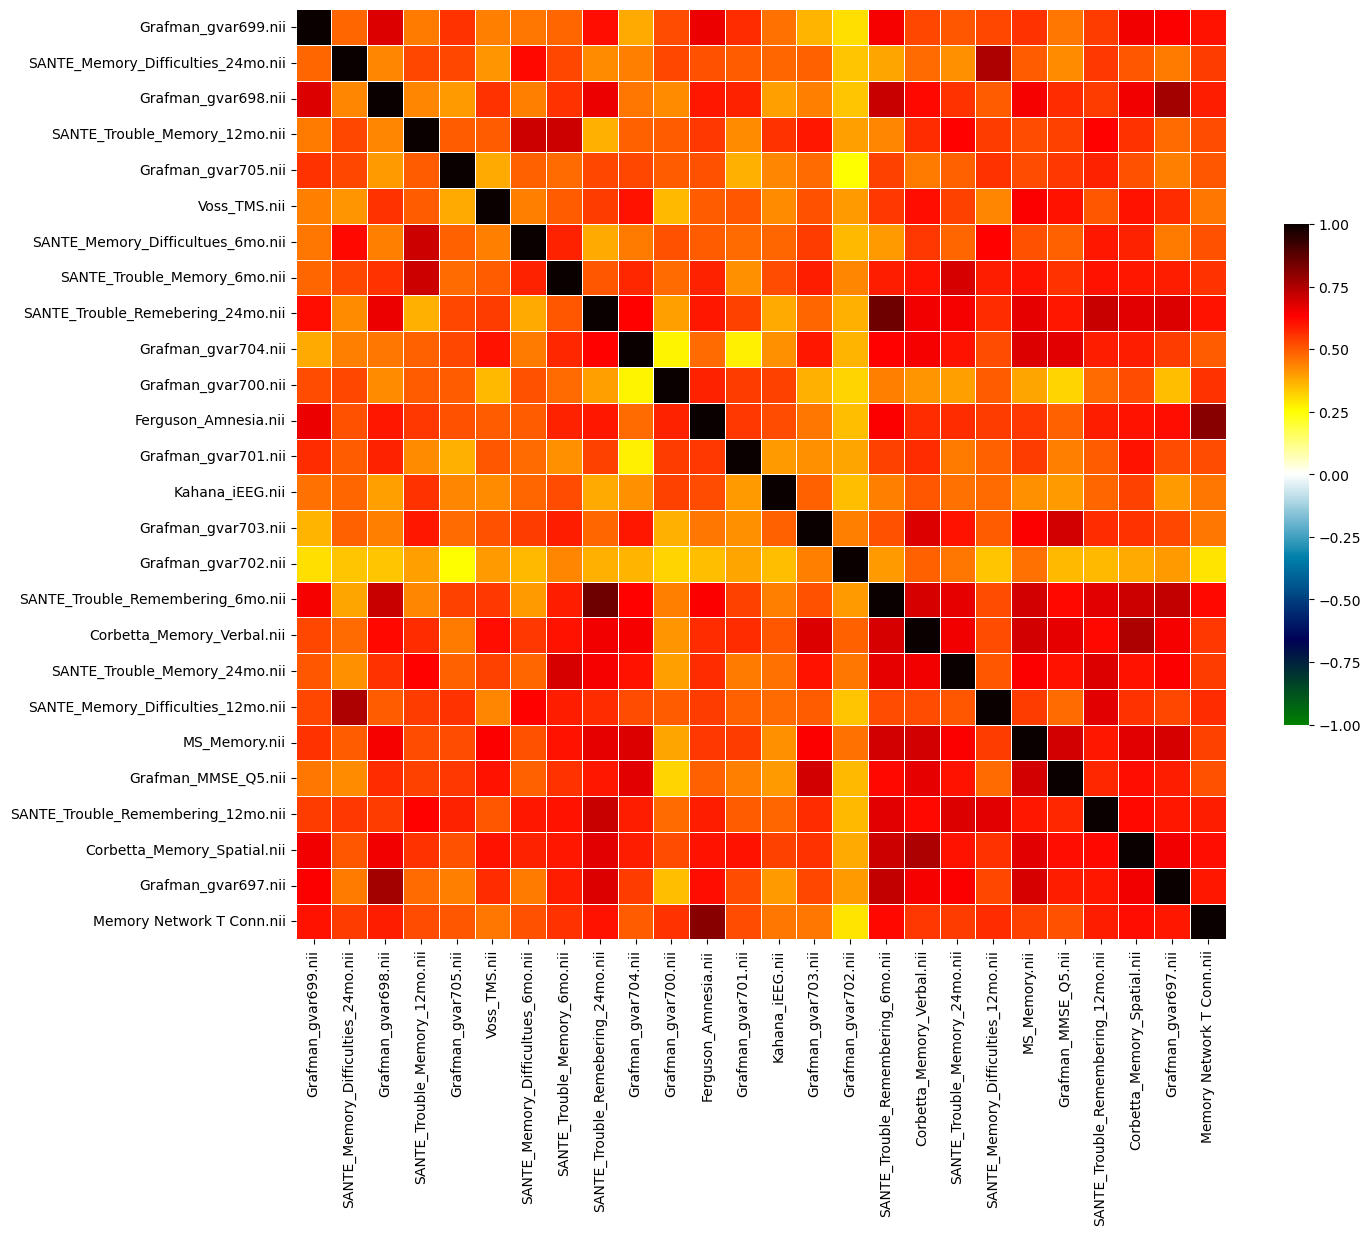

In [ ]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(neg_corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)    

Overall Agreement

In [239]:
display(overall_corr_df)

,Grafman_gvar699.nii,SANTE_Memory_Difficulties_24mo.nii,Grafman_gvar698.nii,SANTE_Trouble_Memory_12mo.nii,Grafman_gvar705.nii,Voss_TMS.nii,SANTE_Memory_Difficultues_6mo.nii,SANTE_Trouble_Memory_6mo.nii,SANTE_Trouble_Remebering_24mo.nii,Grafman_gvar704.nii,...,SANTE_Trouble_Remembering_6mo.nii,Corbetta_Memory_Verbal.nii,SANTE_Trouble_Memory_24mo.nii,SANTE_Memory_Difficulties_12mo.nii,MS_Memory.nii,Grafman_MMSE_Q5.nii,SANTE_Trouble_Remembering_12mo.nii,Corbetta_Memory_Spatial.nii,Grafman_gvar697.nii,Memory Network T Conn.nii
Grafman_gvar699.nii,0.998455,0.490139,0.626227,0.445871,0.574313,0.407172,0.465119,0.433830,0.541555,0.325408,...,0.558662,0.412122,0.440272,0.510878,0.444108,0.398078,0.486684,0.561220,0.562041,0.568279
SANTE_Memory_Difficulties_24mo.nii,0.490139,0.997416,0.406221,0.590320,0.600585,0.444717,0.674521,0.541683,0.392120,0.461038,...,0.314983,0.416327,0.420061,0.771519,0.435854,0.434926,0.559750,0.432804,0.409929,0.559817
Grafman_gvar698.nii,0.626227,0.406221,0.998455,0.389189,0.375816,0.500848,0.409520,0.483558,0.572515,0.368059,...,0.621676,0.505213,0.470047,0.439438,0.525539,0.483865,0.461194,0.535876,0.706965,0.520882
SANTE_Trouble_Memory_12mo.nii,0.445871,0.590320,0.389189,0.997434,0.567431,0.515753,0.738853,0.707120,0.325945,0.494579,...,0.349930,0.507530,0.622981,0.568279,0.447163,0.530046,0.625689,0.482915,0.419648,0.525695
Grafman_gvar705.nii,0.574313,0.600585,0.375816,0.567431,0.998455,0.421819,0.567533,0.493802,0.510590,0.546461,...,0.485437,0.391583,0.495111,0.601913,0.466944,0.561455,0.592251,0.442892,0.407820,0.534006
Voss_TMS.nii,0.407172,0.444717,0.500848,0.515753,0.421819,0.997505,0.470798,0.469590,0.479860,0.580410,...,0.457779,0.529415,0.496546,0.431437,0.561610,0.574384,0.468027,0.514763,0.490694,0.430868
SANTE_Memory_Difficultues_6mo.nii,0.465119,0.674521,0.409520,0.738853,0.567533,0.470798,0.997425,0.590719,0.338462,0.466788,...,0.328520,0.498464,0.477888,0.659318,0.445290,0.490054,0.598951,0.515030,0.400587,0.529726
SANTE_Trouble_Memory_6mo.nii,0.433830,0.541683,0.483558,0.707120,0.493802,0.469590,0.590719,0.997407,0.414804,0.539596,...,0.494326,0.511162,0.654932,0.575592,0.509018,0.515536,0.563155,0.489011,0.513742,0.527098
SANTE_Trouble_Remebering_24mo.nii,0.541555,0.392120,0.572515,0.325945,0.510590,0.479860,0.338462,0.414804,0.997447,0.562756,...,0.795473,0.544716,0.577808,0.516846,0.562711,0.518950,0.658071,0.558143,0.598112,0.542070
Grafman_gvar704.nii,0.325408,0.461038,0.368059,0.494579,0.546461,0.580410,0.466788,0.539596,0.562756,0.998455,...,0.539308,0.566730,0.565331,0.503423,0.605101,0.645181,0.547127,0.483203,0.452749,0.457455


<AxesSubplot: >

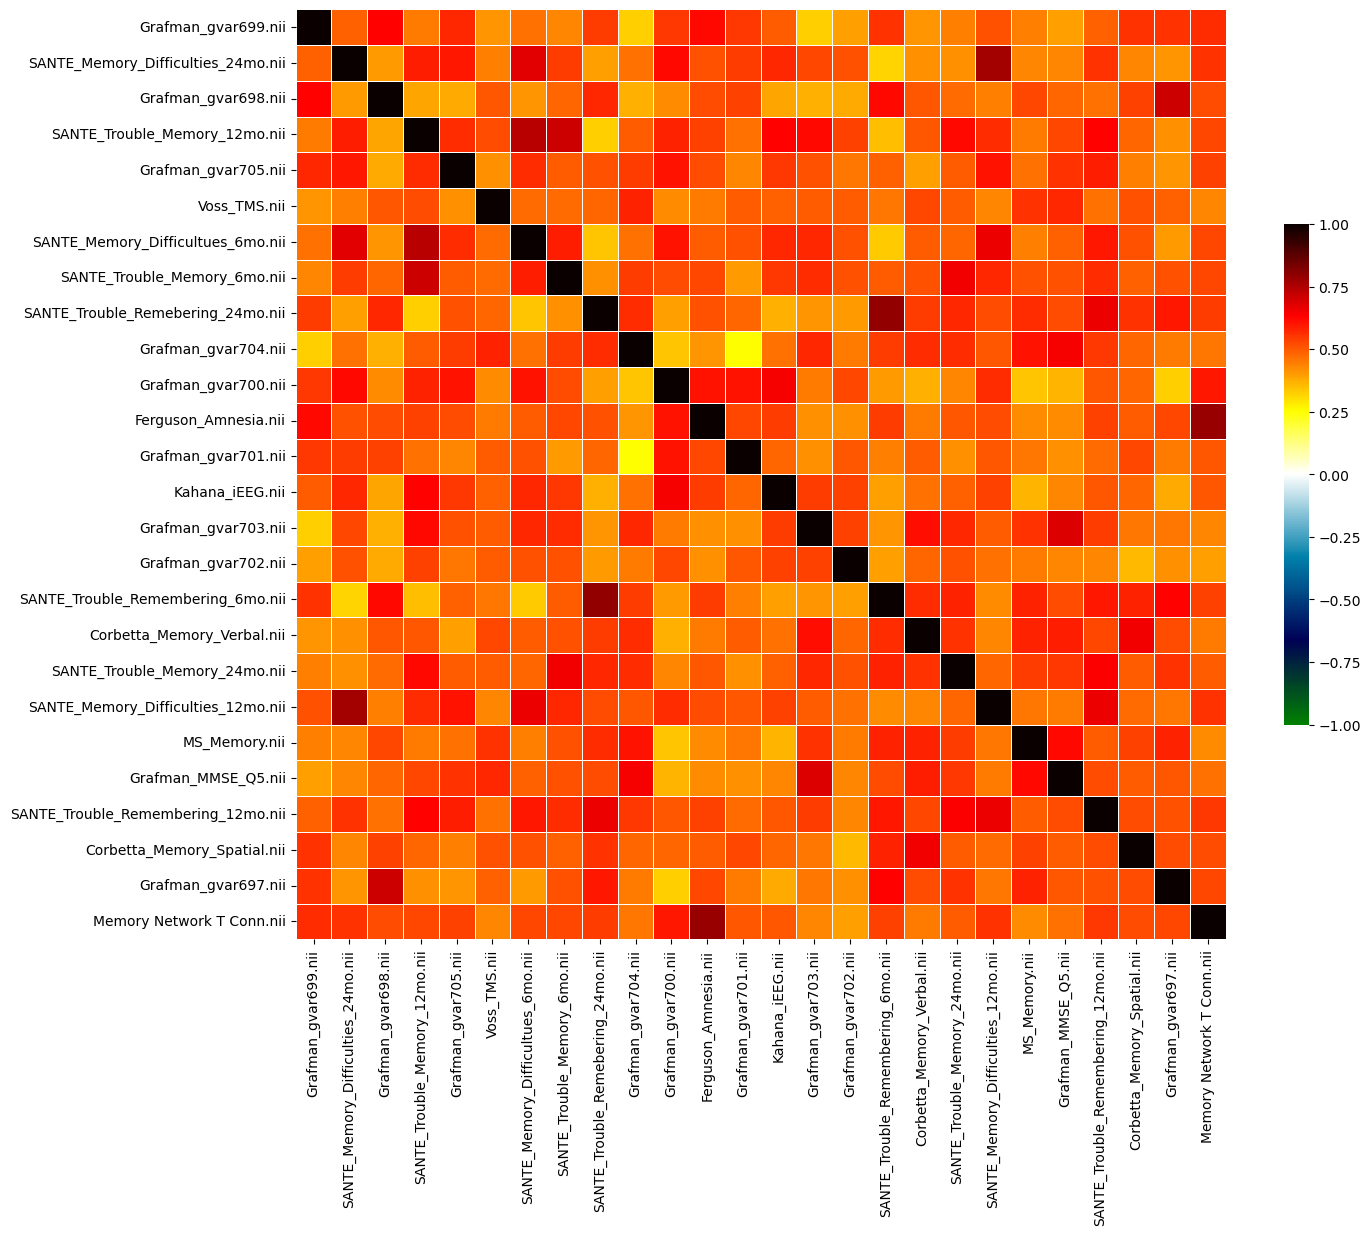

In [240]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(overall_corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)    